In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
#import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


In [6]:
import numpy as np
import scipy.misc
from scipy import ndimage
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
#ff = glob.glob('../SampleXrayImages/80177/view1/*.jpg')
ff = glob.glob('/data/user/wsmonroe/Endodontics/jRosario/data/*.tif')
ff[0]
#ffTest = glob.glob('../SampleXrayImages/80177/view1/anomaly/*')
ffTest = glob.glob('/data/user/wsmonroe/Endodontics/jRosario/Control/*.tif')

In [8]:
len(ff)

224

In [22]:
images = []
imagesTest = []

In [23]:
for f in range(len(ff)):
    #print(ff[f])
    a = Image.open(ff[f]).convert('LA')
    a = np.array(a)
    #a.astype(int)
    a = resize(a, (128, 128),
                       anti_aliasing=True)
    a = ndimage.median_filter(a, 3)
    #a = a[:,:]
    #for i in range(a.shape[1]):
    images.append(a[:,:,0])
print (a.shape)

/home/wsmonroe/.conda/envs/distributedLearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(128, 128, 2)


In [24]:
for f in range(len(ffTest)):
    #print(ff[f])
    a = Image.open(ffTest[f]).convert('LA')
    a = np.array(a)
    a = resize(a, (128, 128),
                       anti_aliasing=True)
    
    #a = a[:,:]
    #for i in range(a.shape[1]):
    imagesTest.append(a[:,:,0])
print (a.shape)

/home/wsmonroe/.conda/envs/distributedLearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(128, 128, 2)


In [25]:
images = np.array(images)
imagesTest = np.array(imagesTest)

In [26]:
images.shape

(224, 128, 128)

In [27]:
images = images.reshape(-1, 128,128,1)
imagesTest = imagesTest.reshape(-1, 128,128,1)


In [28]:
images.shape

(224, 128, 128, 1)

In [29]:
m = np.max(images)
mi = np.min(images)

In [30]:
m, mi

(0.996078431372549, 0.0)

In [31]:
images = (images - mi) / (m - mi)

In [32]:
np.min(images), np.max(images)

(0.0, 1.0)

In [33]:
m = np.max(imagesTest)
mi = np.min(imagesTest)
imagesTest = (imagesTest - mi) / (m - mi)

In [34]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                                             images,
                                                             test_size=0.2,
                                                             random_state=13)

In [35]:
# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images.shape))


Dataset (images) shape: (224, 128, 128, 1)


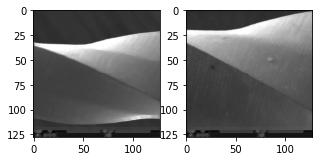

In [36]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[0], (128,128))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[0], (128,128))
plt.imshow(curr_img, cmap='gray')

In [37]:
batch_size = 32
epochs = 1000
inChannel = 1
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))

In [38]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [39]:
autoencoderModel = Model(input_img, autoencoder(input_img))
autoencoderModel.compile(loss='mean_squared_error', optimizer = RMSprop())

In [40]:
autoencoderModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
__________

In [41]:
autoencoder_train = autoencoderModel.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 179 samples, validate on 45 samples
Epoch 1/1000
179/179 [==============================] - 6s 32ms/step - loss: 0.0763 - val_loss: 0.0700
Epoch 2/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 3/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 4/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0147
Epoch 5/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0108
Epoch 6/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 7/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0142
Epoch 8/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0196
Epoch 9/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0141
Epoch 10/1000
179/179 [=============

Epoch 80/1000
179/179 [==============================] - 0s 2ms/step - loss: 9.3196e-04 - val_loss: 0.0056
Epoch 81/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 82/1000
179/179 [==============================] - 0s 2ms/step - loss: 6.5421e-04 - val_loss: 0.0045
Epoch 83/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 84/1000
179/179 [==============================] - 0s 2ms/step - loss: 7.6706e-04 - val_loss: 0.0083
Epoch 85/1000
179/179 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0149
Epoch 86/1000
179/179 [==============================] - 0s 2ms/step - loss: 8.0736e-04 - val_loss: 0.0053
Epoch 87/1000
179/179 [==============================] - 0s 2ms/step - loss: 8.4711e-04 - val_loss: 0.0029
Epoch 88/1000
179/179 [==============================] - 0s 2ms/step - loss: 7.2688e-04 - val_loss: 0.0079
Epoch 89/1000
179/179 [==========================

179/179 [==============================] - 0s 2ms/step - loss: 8.3088e-04 - val_loss: 0.0030
Epoch 157/1000
179/179 [==============================] - 0s 2ms/step - loss: 9.1085e-04 - val_loss: 0.0014
Epoch 158/1000
179/179 [==============================] - 0s 2ms/step - loss: 6.3277e-04 - val_loss: 0.0049
Epoch 159/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.2578e-04 - val_loss: 0.0035
Epoch 160/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.8202e-04 - val_loss: 0.0019
Epoch 161/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.8884e-04 - val_loss: 0.0013
Epoch 162/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.8337e-04 - val_loss: 0.0022
Epoch 163/1000
179/179 [==============================] - 0s 2ms/step - loss: 9.2017e-04 - val_loss: 0.0048
Epoch 164/1000
179/179 [==============================] - 0s 2ms/step - loss: 8.2655e-04 - val_loss: 0.0014
Epoch 165/1000
179/179 [===================

179/179 [==============================] - 0s 2ms/step - loss: 5.0725e-04 - val_loss: 0.0013
Epoch 232/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.5130e-04 - val_loss: 9.8155e-04
Epoch 233/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.8033e-04 - val_loss: 0.0013
Epoch 234/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.8339e-04 - val_loss: 4.4328e-04
Epoch 235/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.1441e-04 - val_loss: 0.0012
Epoch 236/1000
179/179 [==============================] - 0s 2ms/step - loss: 6.5907e-04 - val_loss: 8.0234e-04
Epoch 237/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.3129e-04 - val_loss: 8.0831e-04
Epoch 238/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.3090e-04 - val_loss: 7.1794e-04
Epoch 239/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.2467e-04 - val_loss: 9.1575e-04
Epoch 240/1000
179/

179/179 [==============================] - 0s 2ms/step - loss: 4.5276e-04 - val_loss: 6.4634e-04
Epoch 306/1000
179/179 [==============================] - 0s 2ms/step - loss: 6.9977e-04 - val_loss: 0.0012
Epoch 307/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.0720e-04 - val_loss: 3.4227e-04
Epoch 308/1000
179/179 [==============================] - 0s 2ms/step - loss: 6.2420e-04 - val_loss: 3.9418e-04
Epoch 309/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.8896e-04 - val_loss: 6.2225e-04
Epoch 310/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.8399e-04 - val_loss: 4.6496e-04
Epoch 311/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.5041e-04 - val_loss: 2.4936e-04
Epoch 312/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.3663e-04 - val_loss: 0.0011
Epoch 313/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.1400e-04 - val_loss: 6.6539e-04
Epoch 314/1000


Epoch 379/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.5696e-04 - val_loss: 6.1614e-04
Epoch 380/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.5663e-04 - val_loss: 7.0818e-04
Epoch 381/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.8839e-04 - val_loss: 2.9356e-04
Epoch 382/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.6990e-04 - val_loss: 2.4430e-04
Epoch 383/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.8490e-04 - val_loss: 3.4648e-04
Epoch 384/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.5725e-04 - val_loss: 7.9330e-04
Epoch 385/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.4151e-04 - val_loss: 7.2898e-04
Epoch 386/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.4460e-04 - val_loss: 4.2507e-04
Epoch 387/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.5469e-04 - val_loss: 6.4

179/179 [==============================] - 0s 2ms/step - loss: 3.4118e-04 - val_loss: 3.0636e-04
Epoch 453/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.8761e-04 - val_loss: 2.9451e-04
Epoch 454/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.6162e-04 - val_loss: 5.9849e-04
Epoch 455/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.8271e-04 - val_loss: 6.4108e-04
Epoch 456/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.9980e-04 - val_loss: 8.2393e-04
Epoch 457/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.4906e-04 - val_loss: 0.0011
Epoch 458/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.7219e-04 - val_loss: 3.9602e-04
Epoch 459/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.3644e-04 - val_loss: 3.6970e-04
Epoch 460/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.8956e-04 - val_loss: 7.9162e-04
Epoch 461/1

179/179 [==============================] - 0s 2ms/step - loss: 4.6379e-04 - val_loss: 4.0910e-04
Epoch 526/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.7060e-04 - val_loss: 4.0724e-04
Epoch 527/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.3026e-04 - val_loss: 3.9631e-04
Epoch 528/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.1208e-04 - val_loss: 8.8342e-04
Epoch 529/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.3741e-04 - val_loss: 4.0904e-04
Epoch 530/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.7044e-04 - val_loss: 8.6283e-04
Epoch 531/1000
179/179 [==============================] - 0s 2ms/step - loss: 6.6522e-04 - val_loss: 7.6251e-04
Epoch 532/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.4974e-04 - val_loss: 2.6094e-04
Epoch 533/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.2542e-04 - val_loss: 4.8412e-04
Epoch 5

179/179 [==============================] - 0s 2ms/step - loss: 2.4502e-04 - val_loss: 2.2734e-04
Epoch 599/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.4025e-04 - val_loss: 0.0016
Epoch 600/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.7584e-04 - val_loss: 3.2513e-04
Epoch 601/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.3003e-04 - val_loss: 2.3938e-04
Epoch 602/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.8156e-04 - val_loss: 4.0153e-04
Epoch 603/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.6881e-04 - val_loss: 7.5101e-04
Epoch 604/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.5096e-04 - val_loss: 5.7402e-04
Epoch 605/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.3727e-04 - val_loss: 2.2179e-04
Epoch 606/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.6794e-04 - val_loss: 3.5911e-04
Epoch 607/1

179/179 [==============================] - 0s 2ms/step - loss: 2.3189e-04 - val_loss: 3.2364e-04
Epoch 672/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.2234e-04 - val_loss: 4.7526e-04
Epoch 673/1000
179/179 [==============================] - 0s 2ms/step - loss: 5.9969e-04 - val_loss: 2.1207e-04
Epoch 674/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.9541e-04 - val_loss: 2.4105e-04
Epoch 675/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.1701e-04 - val_loss: 1.4503e-04
Epoch 676/1000
179/179 [==============================] - 0s 2ms/step - loss: 4.5529e-04 - val_loss: 6.0883e-04
Epoch 677/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.0112e-04 - val_loss: 2.4541e-04
Epoch 678/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.4135e-04 - val_loss: 2.4258e-04
Epoch 679/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.0402e-04 - val_loss: 2.3832e-04
Epoch 6

179/179 [==============================] - 0s 2ms/step - loss: 2.4458e-04 - val_loss: 2.5435e-04
Epoch 745/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.0313e-04 - val_loss: 5.1689e-04
Epoch 746/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.0184e-04 - val_loss: 2.1088e-04
Epoch 747/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.6679e-04 - val_loss: 1.9185e-04
Epoch 748/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.7849e-04 - val_loss: 2.0122e-04
Epoch 749/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.6237e-04 - val_loss: 2.8660e-04
Epoch 750/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.8483e-04 - val_loss: 1.6492e-04
Epoch 751/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.7621e-04 - val_loss: 5.6593e-04
Epoch 752/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.4344e-04 - val_loss: 2.3194e-04
Epoch 7

179/179 [==============================] - 0s 2ms/step - loss: 3.9404e-04 - val_loss: 0.0013
Epoch 818/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.5372e-04 - val_loss: 5.6192e-04
Epoch 819/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.8756e-04 - val_loss: 5.9982e-04
Epoch 820/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.4230e-04 - val_loss: 2.1920e-04
Epoch 821/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.2113e-04 - val_loss: 4.5926e-04
Epoch 822/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.9482e-04 - val_loss: 2.8180e-04
Epoch 823/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.3586e-04 - val_loss: 1.7888e-04
Epoch 824/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.3631e-04 - val_loss: 2.6946e-04
Epoch 825/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.6464e-04 - val_loss: 3.4933e-04
Epoch 826/1

179/179 [==============================] - 0s 2ms/step - loss: 1.7873e-04 - val_loss: 4.7711e-04
Epoch 891/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.9985e-04 - val_loss: 2.8552e-04
Epoch 892/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.2851e-04 - val_loss: 6.9592e-04
Epoch 893/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.1128e-04 - val_loss: 3.9160e-04
Epoch 894/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.3576e-04 - val_loss: 2.5260e-04
Epoch 895/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.2822e-04 - val_loss: 1.3470e-04
Epoch 896/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.5351e-04 - val_loss: 1.7504e-04
Epoch 897/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.1855e-04 - val_loss: 2.7028e-04
Epoch 898/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.5031e-04 - val_loss: 2.3682e-04
Epoch 8

179/179 [==============================] - 0s 2ms/step - loss: 1.4046e-04 - val_loss: 3.8233e-04
Epoch 964/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.7801e-04 - val_loss: 2.0220e-04
Epoch 965/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.7098e-04 - val_loss: 3.7043e-04
Epoch 966/1000
179/179 [==============================] - 0s 2ms/step - loss: 3.8668e-04 - val_loss: 4.2550e-04
Epoch 967/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.7969e-04 - val_loss: 1.8791e-04
Epoch 968/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.4041e-04 - val_loss: 1.9714e-04
Epoch 969/1000
179/179 [==============================] - 0s 2ms/step - loss: 1.9233e-04 - val_loss: 4.0850e-04
Epoch 970/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.3126e-04 - val_loss: 1.1926e-04
Epoch 971/1000
179/179 [==============================] - 0s 2ms/step - loss: 2.0778e-04 - val_loss: 2.8574e-04
Epoch 9

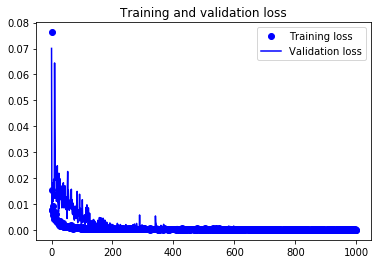

In [42]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1000)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [43]:
autoencoderOut = autoencoderModel.save_weights('autoencoder_sem.h5')

In [44]:
autoencoderRebuild = Model(input_img, autoencoder(input_img))


In [45]:
autoencoderRebuild.load_weights('autoencoder_sem.h5')

In [46]:
pred = autoencoderRebuild.predict(imagesTest)
predN = autoencoderRebuild.predict(images)

Test Images


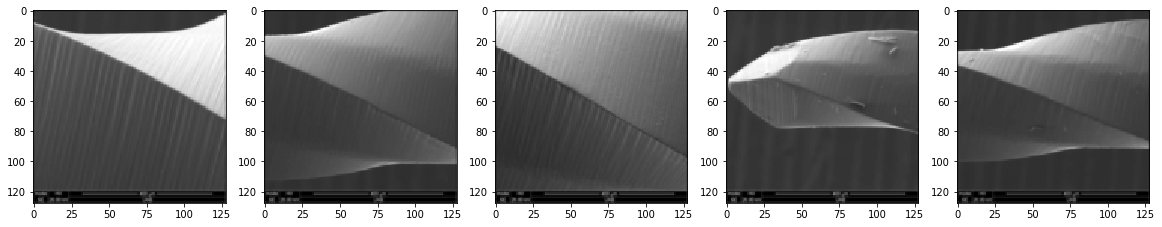

Reconstruction of Test Images


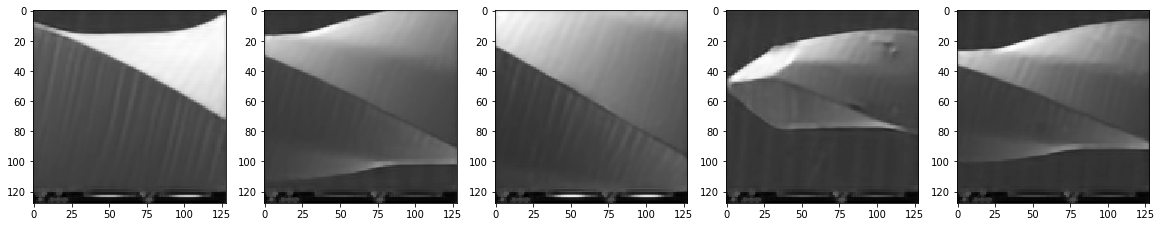

Difference of Anomaly Images


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

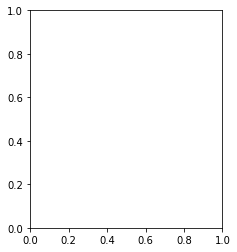

In [48]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(imagesTest[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()
plt.figure(figsize=(20, 4))
print("Difference of Anomaly Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow((pred[i, ..., 0]-imagesTest[i,...,0]), cmap='gray') 
    print(np.array(pred[i, ..., 0]-imagesTest[i,...,0]).min())
plt.show()
plt.figure(figsize=(20, 4))
print("Difference of Regular Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(predN[i, ..., 0]-images[i,...,0], cmap='gray') 
    print(np.array(predN[i, ..., 0]-images[i,...,0]).min())
plt.show()